In [76]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import axes3d
from matplotlib import cm

### Simulación recurrencia n perros

1. Funciones auxiliares

In [77]:
#plotea P_t(m) en 3d
def plots(n_fleas,n_steps,Z):
    
    y = np.linspace(0,n_steps,n_steps+1)
    x = np.linspace(0,n_fleas, n_fleas+1)
    X, Y = np.meshgrid(x, y)
    fig = plt.figure()
    ax = fig.gca(projection='3d')
    surf = ax.plot_surface(Y,X, Z, cmap=cm.coolwarm,
                           linewidth=0, antialiased=False)
    fig.colorbar(surf, shrink=0.5, aspect=5)

    plt.show()
    
    fig2 = plt.figure()
    ax2 = fig2.add_subplot(111, projection='3d')
    ax2.plot_wireframe(Y,X, Z, rstride=10, cstride=10)
    plt.show()
    
    im = plt.imshow(P_vector, cmap='hot', aspect='auto')
    plt.colorbar(im, orientation='vertical')
    plt.show()

In [78]:
def initialize(n_steps,n_fleas):
    P = np.zeros((n_steps+1,n_fleas+1))
    P[0,0] = 1
    return P
    
    
def Recurrence(a,b,c,m,n_fleas,ndogs):
    d = (m+1)/n_fleas*a+(n_fleas+1-m)/(n_fleas*(n_dogs-1))*b+ (n_dogs-2)*(n_fleas-m)/(n_fleas*(n_dogs-1))*c
    return d
    
def Recurrence_bound(a,b,n_fleas,n_dogs,flag):
    if flag == 0:
        d = a/n_fleas + (n_dogs-2)*(n_fleas)/(n_fleas*(n_dogs-1))*b
    else:
        d = a/(n_fleas*(n_dogs-1))
    return d
    
#Obtiene P_(t+1) dado P_t  
def get_next(P_t,n_fleas,n_dogs):
    
    P_next = np.zeros(n_fleas+1)
    P_next[0] = Recurrence_bound(P_t[1],P_t[0],n_fleas,n_dogs,0)
    for m in range(1,n_fleas):
        P_next[m] = Recurrence(P_t[m+1],P_t[m-1],P_t[m],m,n_fleas,n_dogs)
    P_next[-1] = Recurrence_bound(P_t[n_fleas-1],0,n_fleas,n_dogs,1)
    
    return P_next


def evolve(P_vector,n_fleas,n_dogs,t):
    for time in range(t):
        P_vector[time+1][:] = get_next(P_vector[time],n_fleas,n_dogs)


1.1 Main

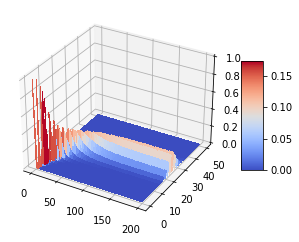

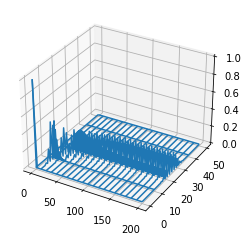

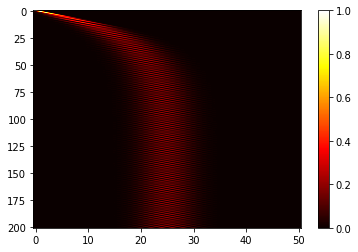

In [81]:
# main
n_dogs = 2
n_fleas = 50
n_steps = 200
P_vector = initialize(n_steps,n_fleas) # contiene las probabilidades en el tiempo
evolve(P_vector,n_fleas,n_dogs,n_steps)
plots(n_fleas,n_steps,P_vector)